<a href="https://colab.research.google.com/github/busraminal/computer_vision/blob/main/Untitled29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


===== ÇALIŞTIRILIYOR: 1 =====


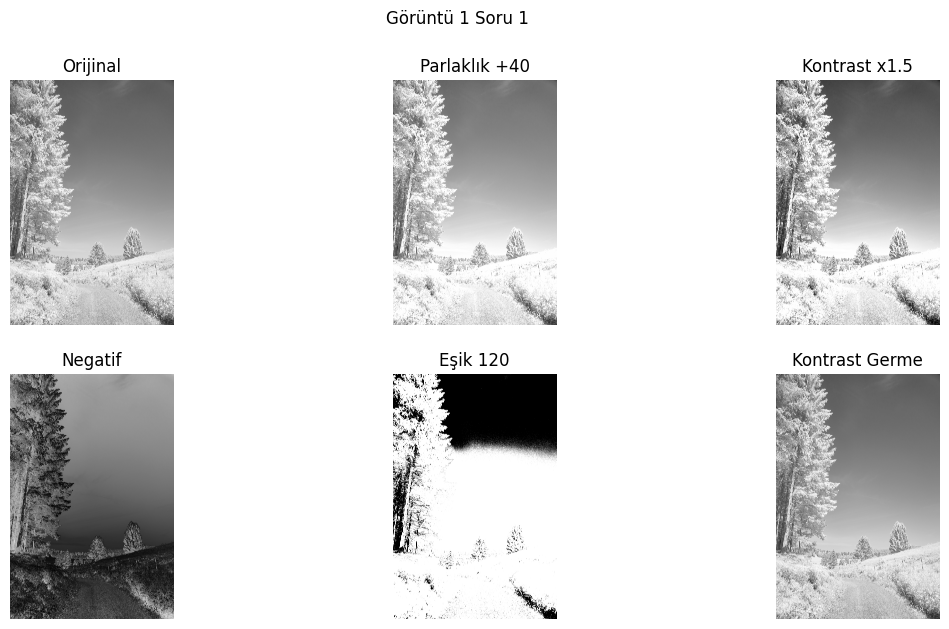

Görüntü 1 Mean=160.36  Std=46.92  Entropy=7.397  Min=1  Max=255


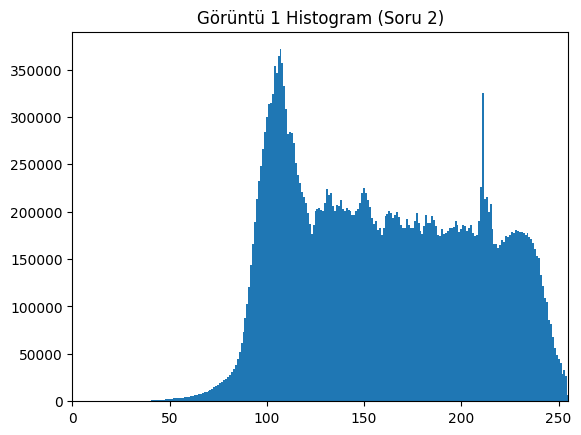

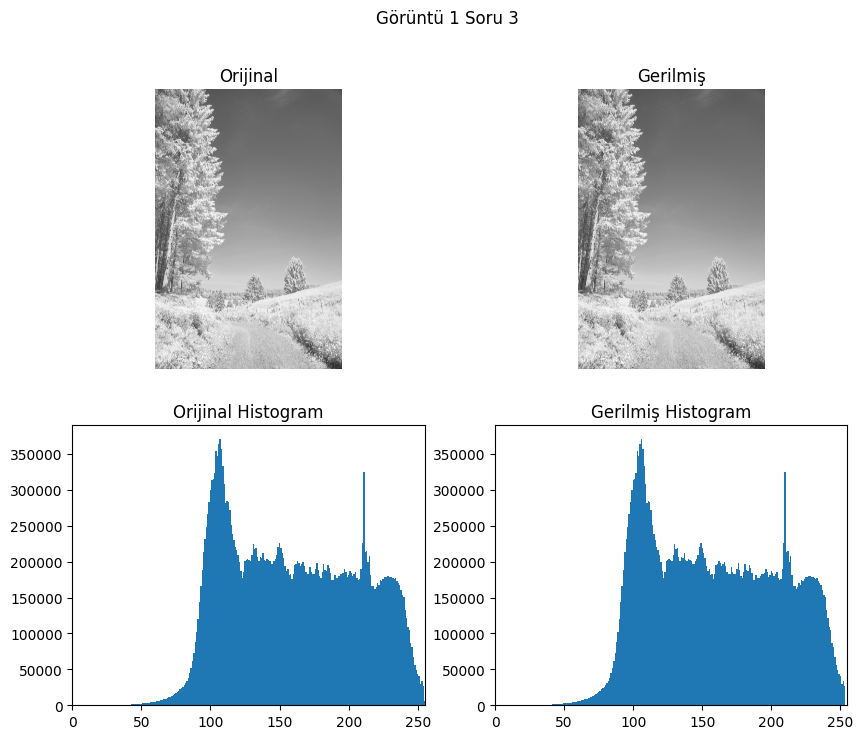

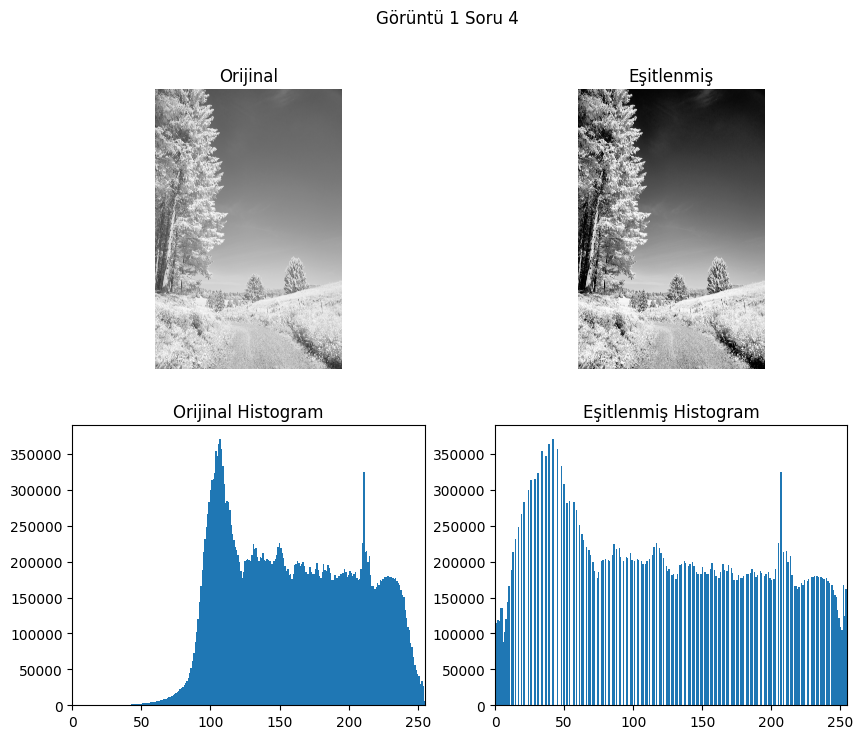

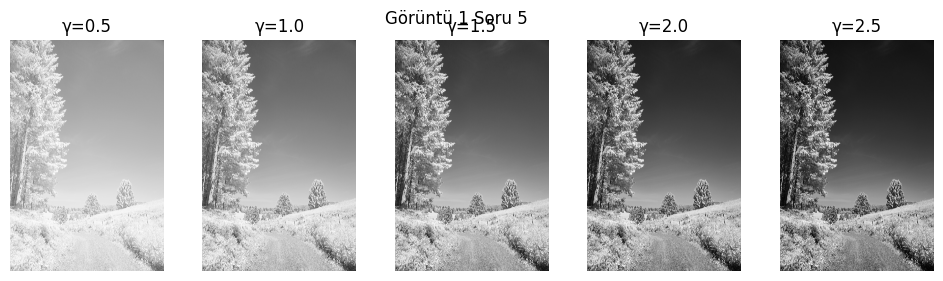


===== ÇALIŞTIRILIYOR: 2 =====


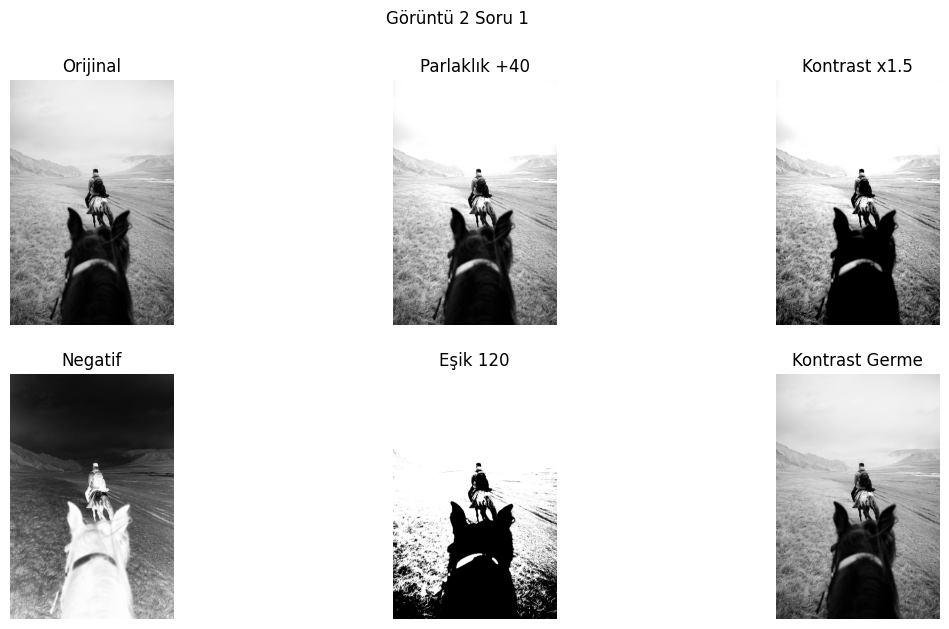

Görüntü 2 Mean=154.44  Std=79.70  Entropy=7.457  Min=0  Max=255


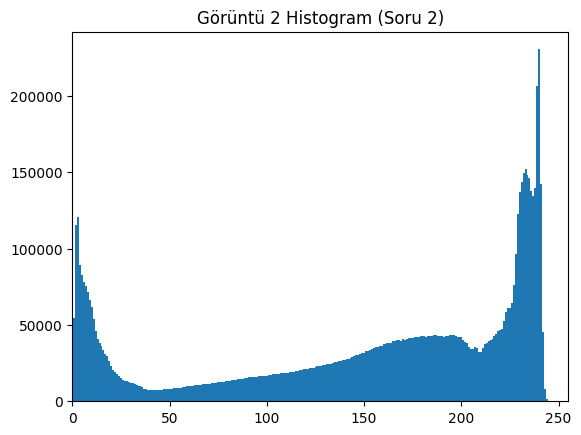

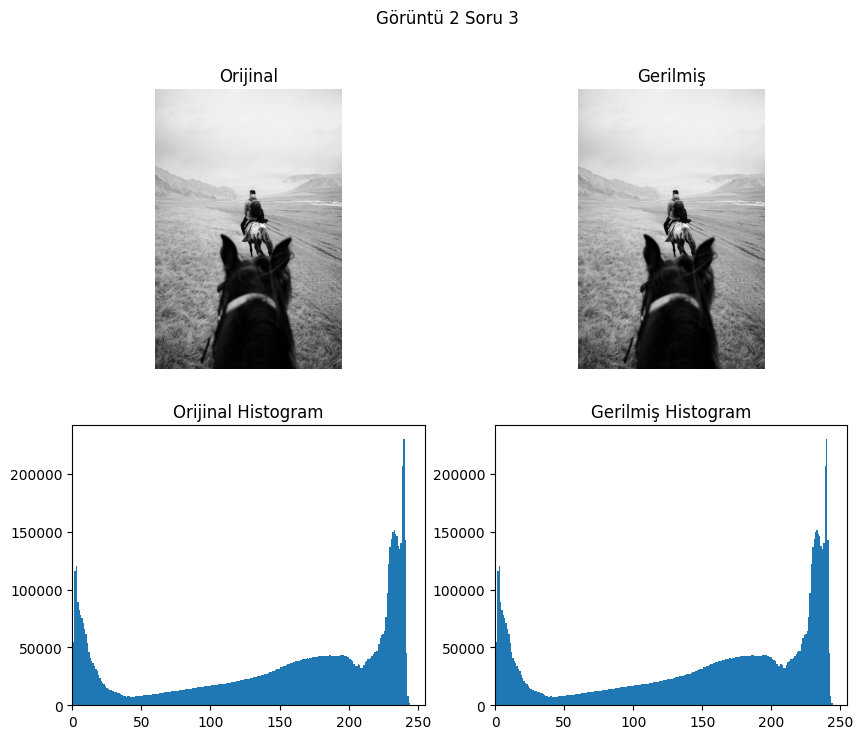

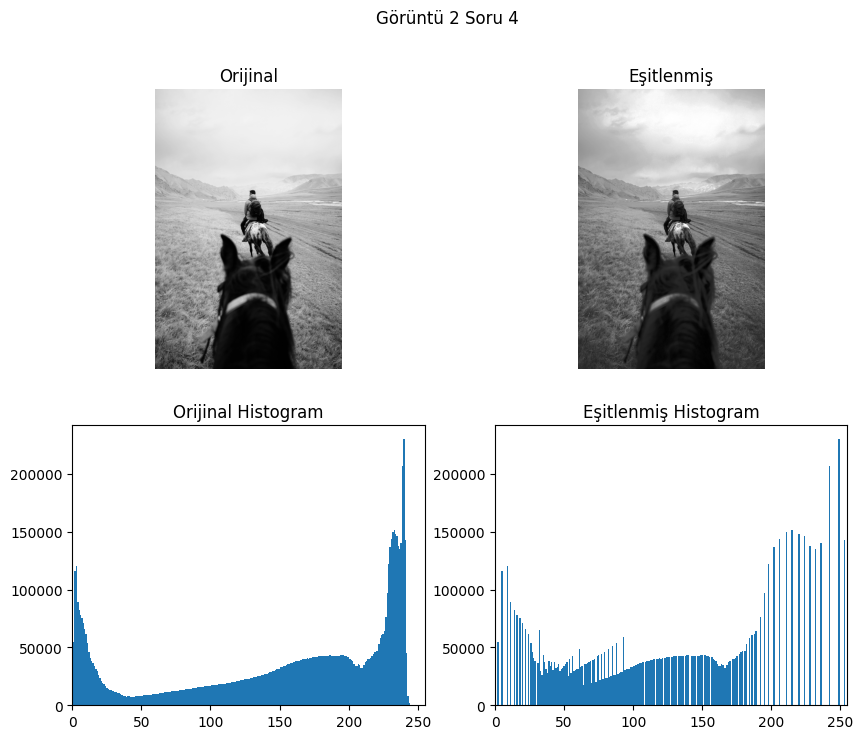

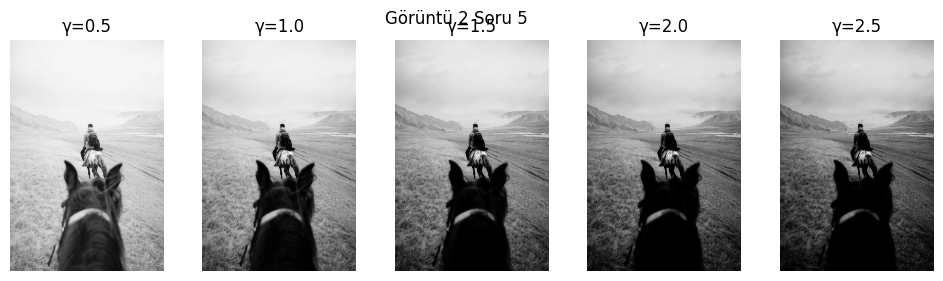


===== ÇALIŞTIRILIYOR: 3 =====


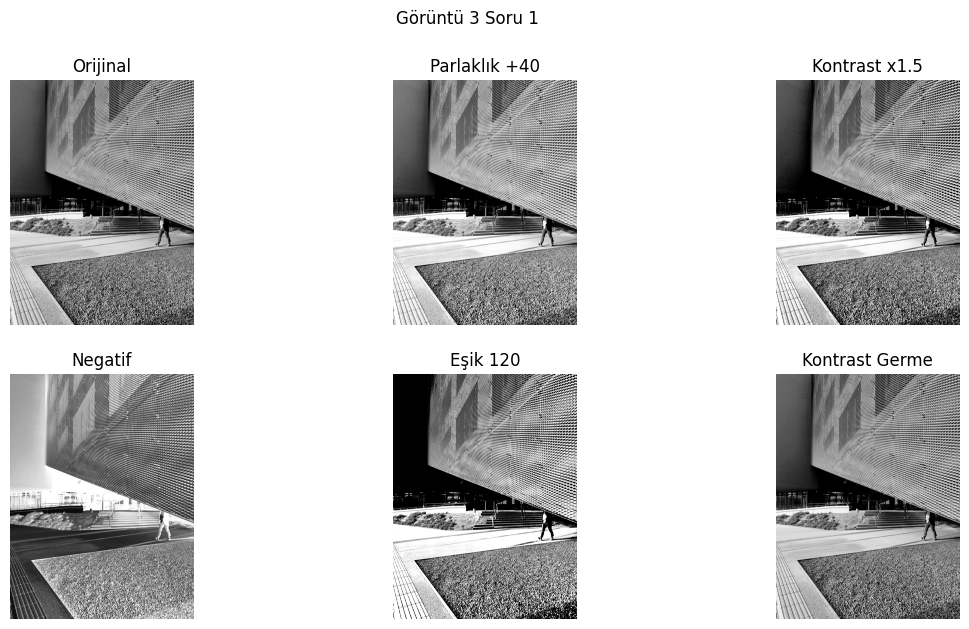

Görüntü 3 Mean=122.43  Std=86.60  Entropy=7.685  Min=0  Max=255


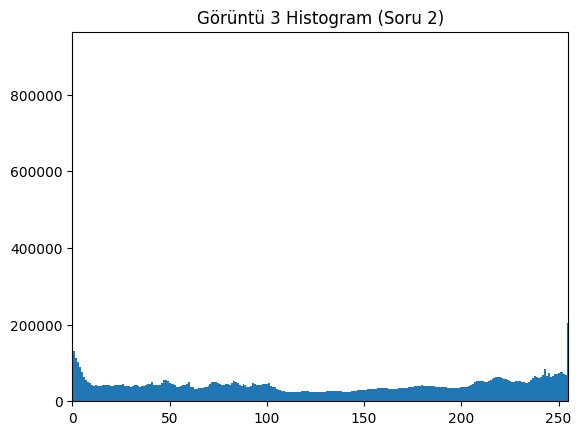

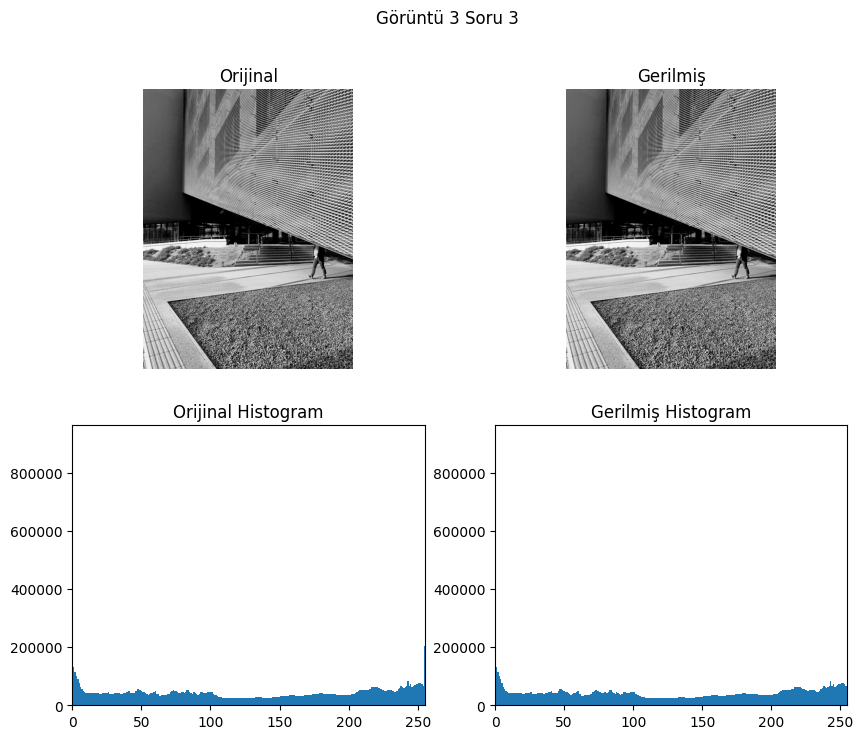

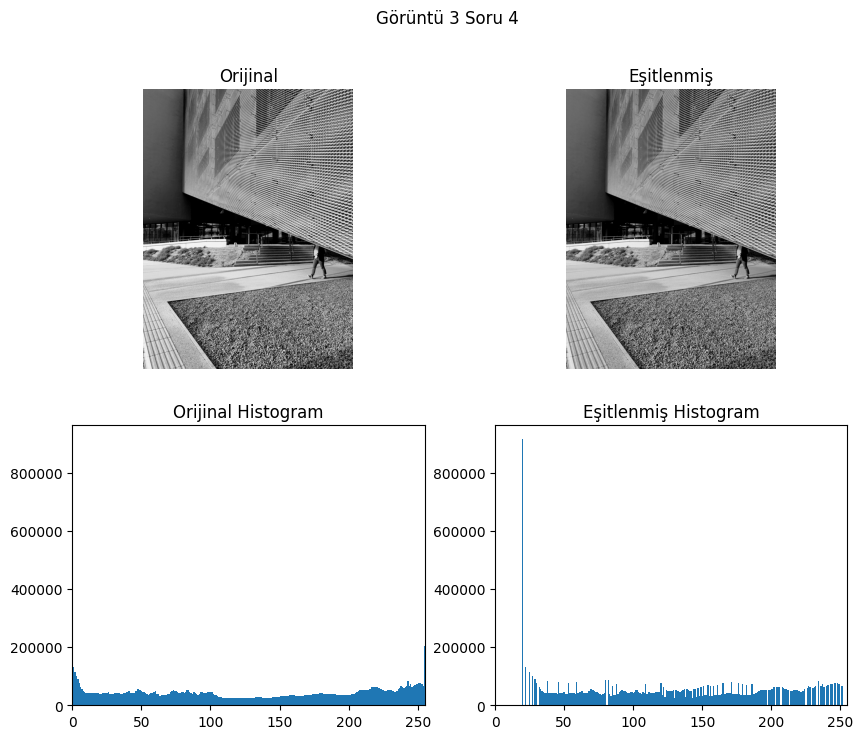

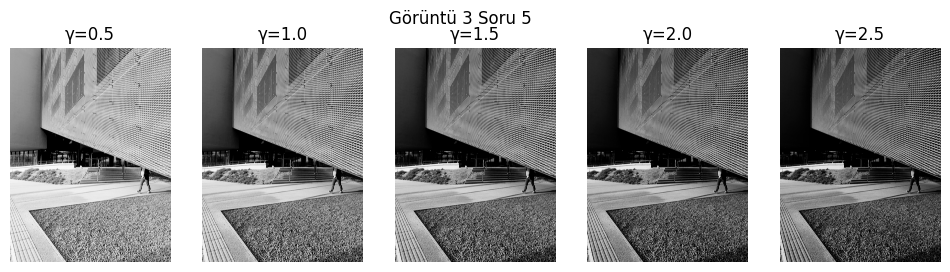

In [2]:
"""
Bilgisayarla Görü - Ödev 3
Nokta İşlemleri + Histogram + Kontrast Germe + Histogram Eşitleme + Gamma Düzeltme

Kullanım:
 - 1, 2, 3 isimli görüntüleri bu dosya ile aynı klasöre koy.
 - Görüntü renkli olabilir → kod otomatik griye çevirir.
 - Sonra: python odev3.py
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import os

# =========================================================
#  GÖRÜNTÜ DOSYA ADINI BUL
# =========================================================
def resolve_path(basename):
    """
    Örn: '1' yazdıysan, 1.png, 1.jpg vb. var mı diye sırayla bakar.
    Bulduğunu geri döndürür.
    """
    extensions = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
    for ext in extensions:
        candidate = basename + ext
        if os.path.exists(candidate):
            return candidate

    # Eğer dosya uzantısız verilmişse onu da kontrol et
    if os.path.exists(basename):
        return basename

    raise FileNotFoundError(f"Dosya bulunamadı: {basename}.*")

# =========================================================
#  GÖRÜNTÜYÜ GRİ OKUMA
# =========================================================
def load_as_gray(path):
    """
    Görüntüyü açar → gri yapar → numpy array'e çevirir.
    (uint8 = 0-255 aralığı)
    """
    return np.array(Image.open(path).convert("L"), dtype=np.uint8)

# =========================================================
# SORU 1: Nokta İşlemleri
# =========================================================

def adjust_brightness(img, value):
    """
    Parlaklık: tüm piksellere sabit ekler veya çıkarır.
    Sonuç 0-255 dışına taşmasın diye clip yaparız.
    """
    out = img.astype(np.int16) + value   # önce geniş aralıkta topluyoruz
    return np.clip(out, 0, 255).astype(np.uint8)

def adjust_contrast(img, factor):
    """
    Kontrast formülü:
    output = factor * (pixel - 128) + 128
    128 → gri denge noktası
    """
    out = factor * (img.astype(np.float32) - 128) + 128
    return np.clip(out, 0, 255).astype(np.uint8)

def negative(img):
    """Negatif görüntü: parlak olan koyulaşır, koyu olan aydınlanır."""
    return 255 - img

def threshold(img, t):
    """Eşikleme: t'den büyük ise 255, değilse 0."""
    return np.where(img > t, 255, 0).astype(np.uint8)

# =========================================================
# SORU 2: Histogram + İstatistik
# =========================================================

def histogram_manual(img):
    """
    Hazır histogram fonksiyonu KULLANMADAN
    her gri değerin kaç kez geçtiğini sayarız.
    """
    return np.bincount(img.ravel(), minlength=256)

def stats(img):
    """
    Ortalama, Standart Sapma, Entropi, Min, Max hesaplar.
    Entropi: görüntüdeki gri değer çeşitliliğini ölçer.
    """
    hist = histogram_manual(img)
    N = img.size
    p = hist / N   # olasılık dağılımı
    entropy = -np.sum(p[p > 0] * np.log2(p[p > 0]))
    return np.mean(img), np.std(img), entropy, img.min(), img.max()

def plot_hist(ax, hist, title):
    """Histogramı çubuk grafik olarak çizer."""
    ax.bar(np.arange(256), hist, width=1.0)
    ax.set_title(title)
    ax.set_xlim(0, 255)

# =========================================================
# SORU 3: Kontrast Germe
# =========================================================

def contrast_stretch(img):
    """
    Min-max normalizasyonu ile görüntüyü 0-255 aralığına yayar.
    Koyu bölgeler açılır, parlaklık dağılımı genişler.
    """
    mn, mx = img.min(), img.max()
    if mx == mn:  # tüm piksel aynıysa olduğu gibi döndür
        return img.copy()
    stretched = (img - mn) / (mx - mn) * 255
    return stretched.astype(np.uint8)

# =========================================================
# SORU 4: Histogram Eşitleme (manuel)
# =========================================================

def hist_equalize_manual(img):
    """
    1) Histogram → Normalize CDF
    2) CDF'yi LUT (lookup table) haline getir
    3) Her pikseli LUT üzerinden dönüştür
    """
    hist = histogram_manual(img).astype(float)
    cdf = np.cumsum(hist) / img.size
    lut = np.round(255 * cdf).astype(np.uint8)
    return lut[img]

# =========================================================
# SORU 5: Gamma Düzeltme
# =========================================================

def gamma_correct(img, gamma):
    """
    Karanlık bölgeleri açmak veya parlak bölgeleri düzeltmek için kullanılır.
    gamma < 1 → görüntü aydınlanır
    gamma > 1 → görüntü karanlıklaşır
    """
    x = img.astype(np.float32) / 255.0
    y = 255.0 * (x ** gamma)
    return y.astype(np.uint8)

# =========================================================
#  GÖSTERİM FONKSİYONLARI (GRAFİKLER)
# =========================================================

def visualize_point_ops(img, title_prefix=""):
    """Soru 1 sonuçlarını 2x3 panelde yan yana göster."""
    plt.figure(figsize=(14, 7))
    imgs = [
        ("Orijinal", img),
        ("Parlaklık +40", adjust_brightness(img, 40)),
        ("Kontrast x1.5", adjust_contrast(img, 1.5)),
        ("Negatif", negative(img)),
        ("Eşik 120", threshold(img, 120)),
        ("Kontrast Germe", contrast_stretch(img)),
    ]
    for i, (t, im) in enumerate(imgs, start=1):
        plt.subplot(2,3,i); plt.imshow(im, cmap="gray"); plt.title(t); plt.axis("off")
    plt.suptitle(title_prefix + " Soru 1")
    plt.show()

def visualize_histogram_and_stats(img, title_prefix=""):
    """Histogram + sayısal istatistikleri yazdır."""
    h = histogram_manual(img)
    m,s,e,mn,mx = stats(img)
    print(f"{title_prefix} Mean={m:.2f}  Std={s:.2f}  Entropy={e:.3f}  Min={mn}  Max={mx}")
    plt.figure(); plot_hist(plt.gca(), h, title_prefix + " Histogram (Soru 2)"); plt.show()

def visualize_contrast_stretch(img, title_prefix=""):
    """Kontrast germe için 2x2 panel."""
    stretched = contrast_stretch(img)
    h1 = histogram_manual(img)
    h2 = histogram_manual(stretched)

    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1); plt.imshow(img, cmap="gray"); plt.title("Orijinal"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(stretched, cmap="gray"); plt.title("Gerilmiş"); plt.axis("off")
    plt.subplot(2,2,3); plot_hist(plt.gca(), h1, "Orijinal Histogram")
    plt.subplot(2,2,4); plot_hist(plt.gca(), h2, "Gerilmiş Histogram")
    plt.suptitle(title_prefix + " Soru 3")
    plt.show()

def visualize_equalization(img, title_prefix=""):
    """Histogram eşitleme için 2x2 panel."""
    eq = hist_equalize_manual(img)
    h1 = histogram_manual(img)
    h2 = histogram_manual(eq)

    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1); plt.imshow(img, cmap="gray"); plt.title("Orijinal"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(eq, cmap="gray"); plt.title("Eşitlenmiş"); plt.axis("off")
    plt.subplot(2,2,3); plot_hist(plt.gca(), h1, "Orijinal Histogram")
    plt.subplot(2,2,4); plot_hist(plt.gca(), h2, "Eşitlenmiş Histogram")
    plt.suptitle(title_prefix + " Soru 4")
    plt.show()

def visualize_gamma_series(img, title_prefix=""):
    """Gamma düzeltmelerini yan yana göster."""
    gammas = [0.5,1.0,1.5,2.0,2.5]
    plt.figure(figsize=(12,3))
    for i,g in enumerate(gammas):
        plt.subplot(1,5,i+1); plt.imshow(gamma_correct(img,g), cmap="gray")
        plt.title(f"γ={g}"); plt.axis("off")
    plt.suptitle(title_prefix + " Soru 5")
    plt.show()

# =========================================================
#   ANA ÇALIŞMA DÖNGÜSÜ
# =========================================================

def run(basename):
    path = resolve_path(basename)
    img = load_as_gray(path)

    visualize_point_ops(img, f"Görüntü {basename}")
    visualize_histogram_and_stats(img, f"Görüntü {basename}")
    visualize_contrast_stretch(img, f"Görüntü {basename}")
    visualize_equalization(img, f"Görüntü {basename}")
    visualize_gamma_series(img, f"Görüntü {basename}")

if __name__ == "__main__":
    for b in ["1","2","3"]:
        print("\n===== ÇALIŞTIRILIYOR:", b, "=====")
        run(b)


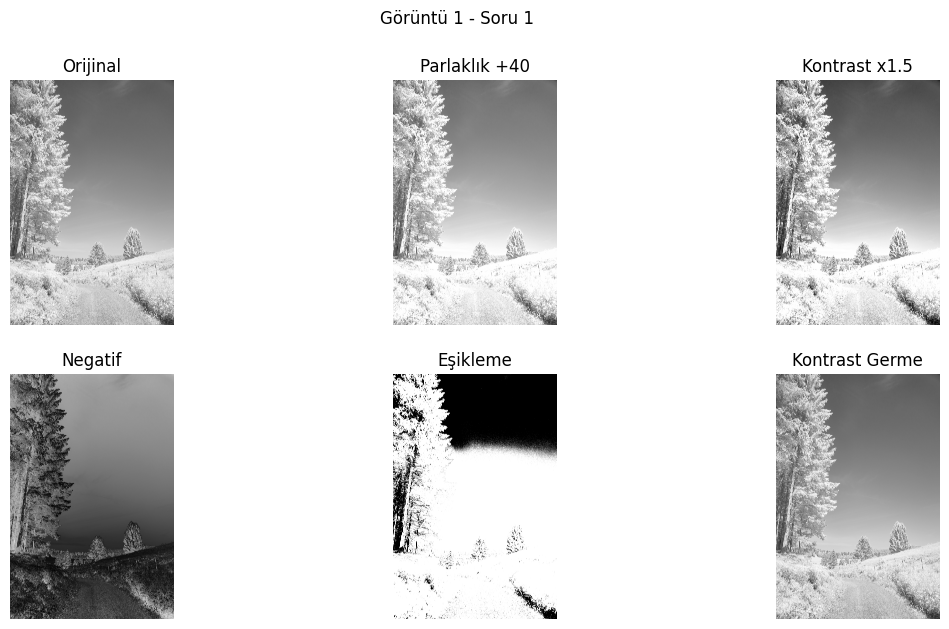

Görüntü 1 Soru 2 -> Mean=160.36, Std=46.92, Entropy=7.397, Min=1, Max=255


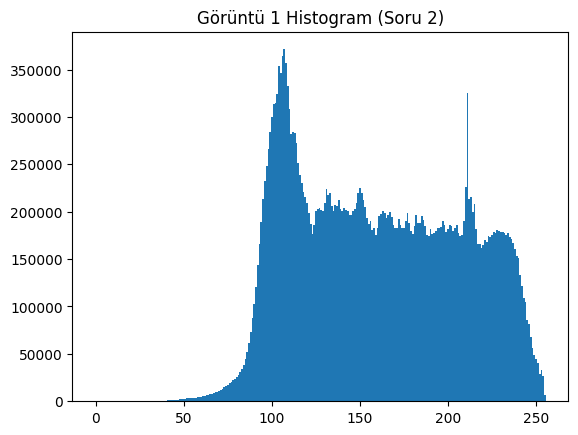

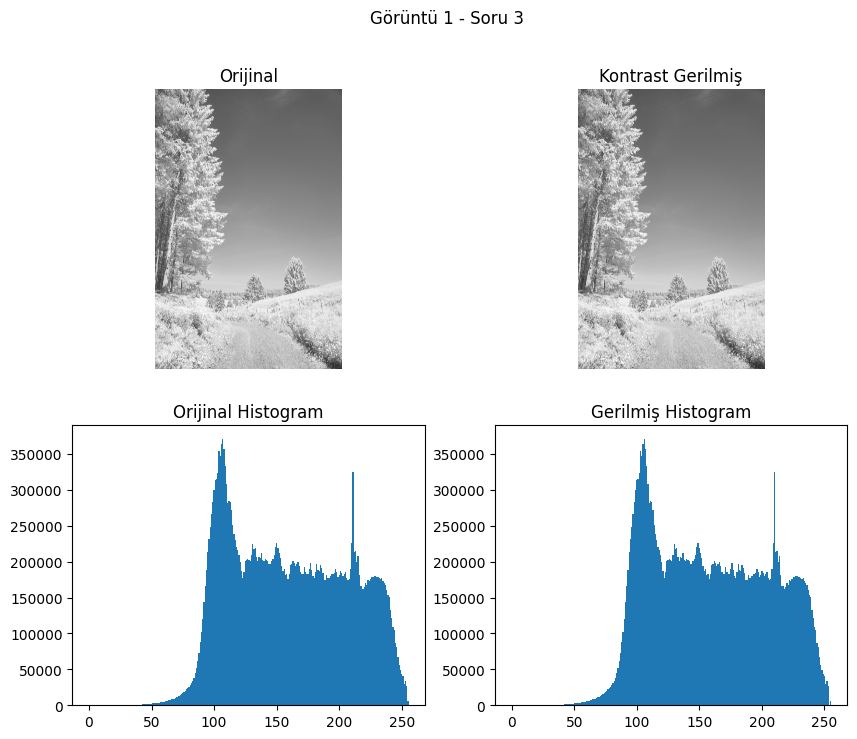

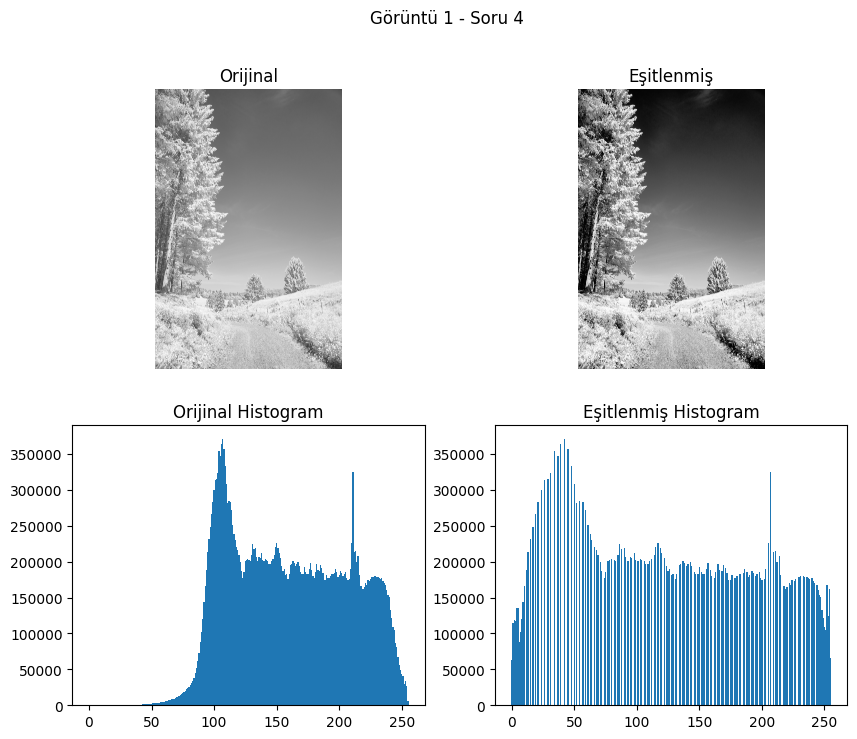

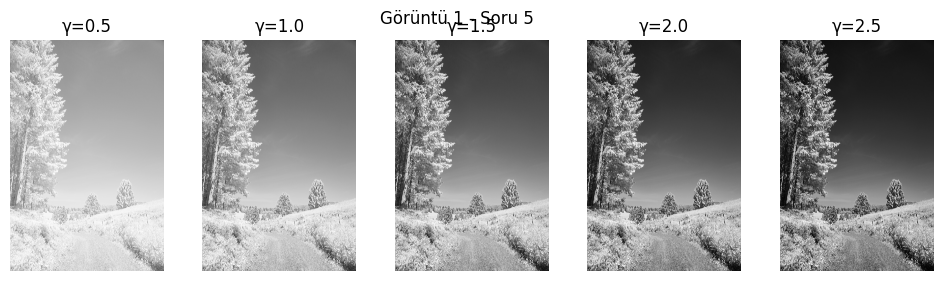

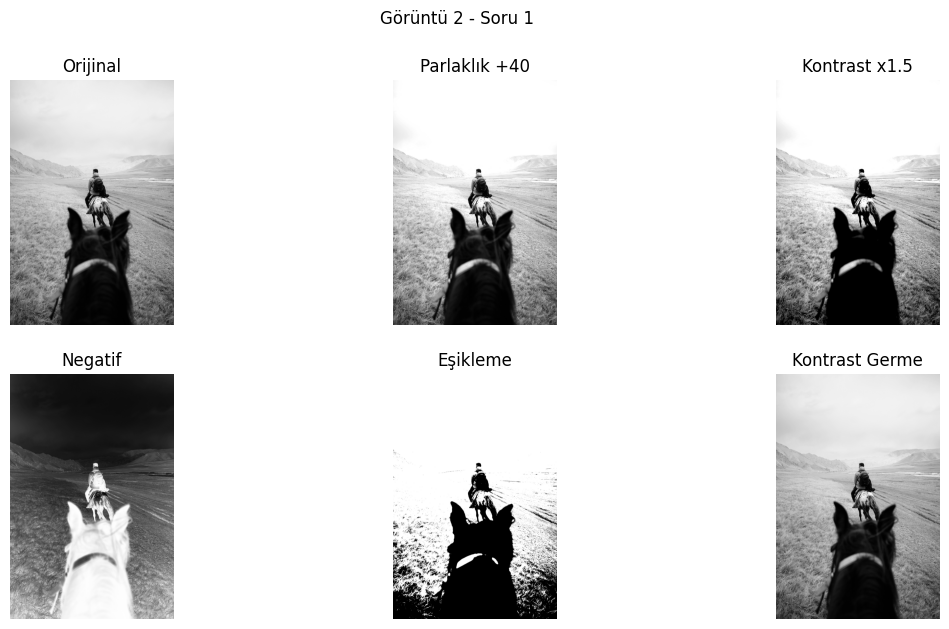

Görüntü 2 Soru 2 -> Mean=154.44, Std=79.70, Entropy=7.457, Min=0, Max=255


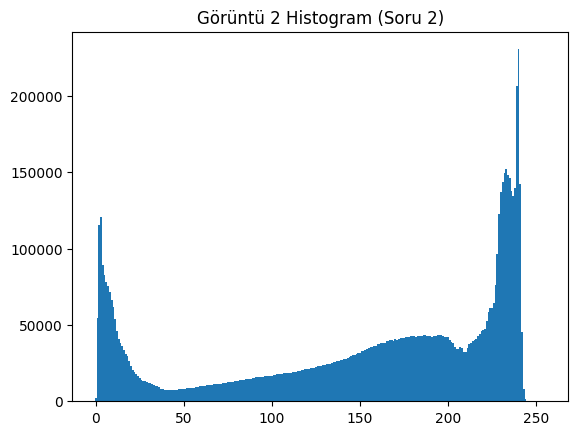

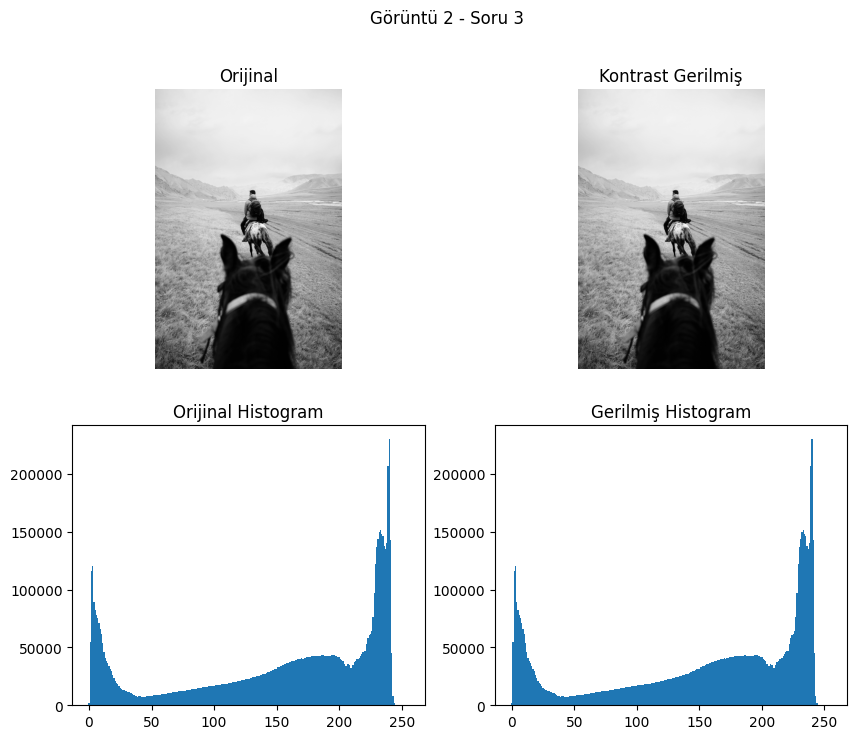

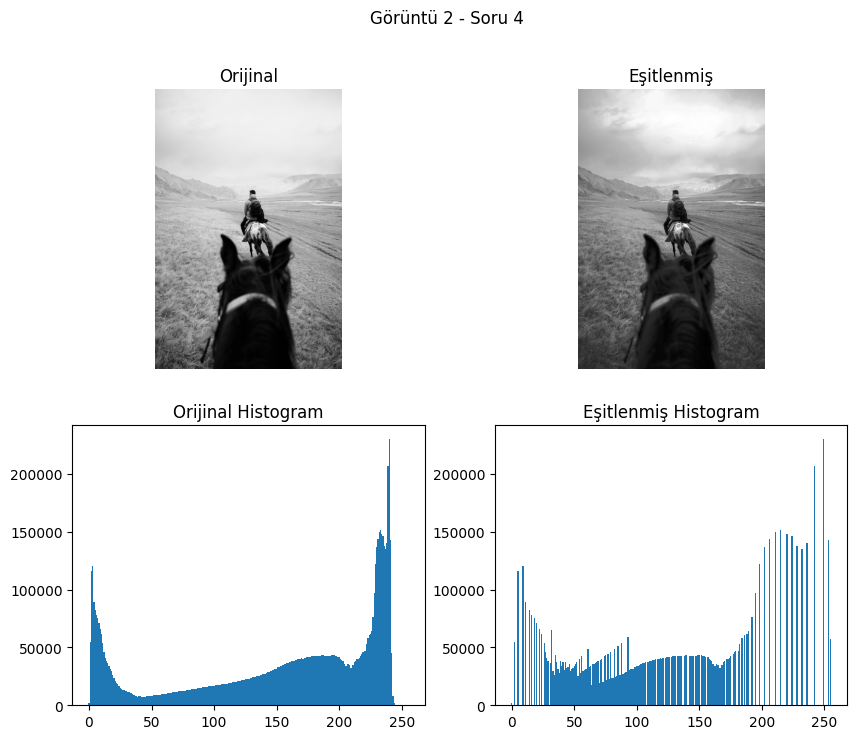

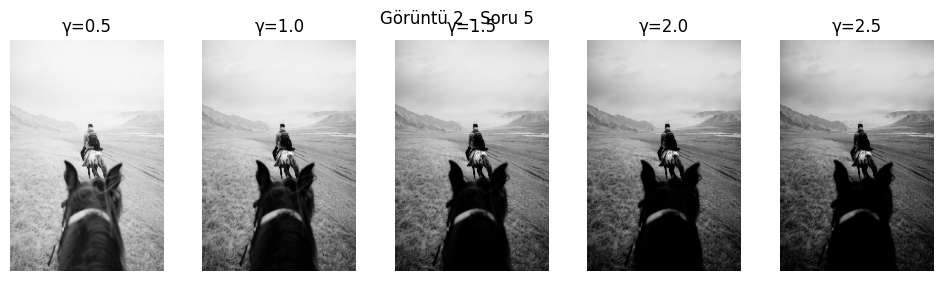

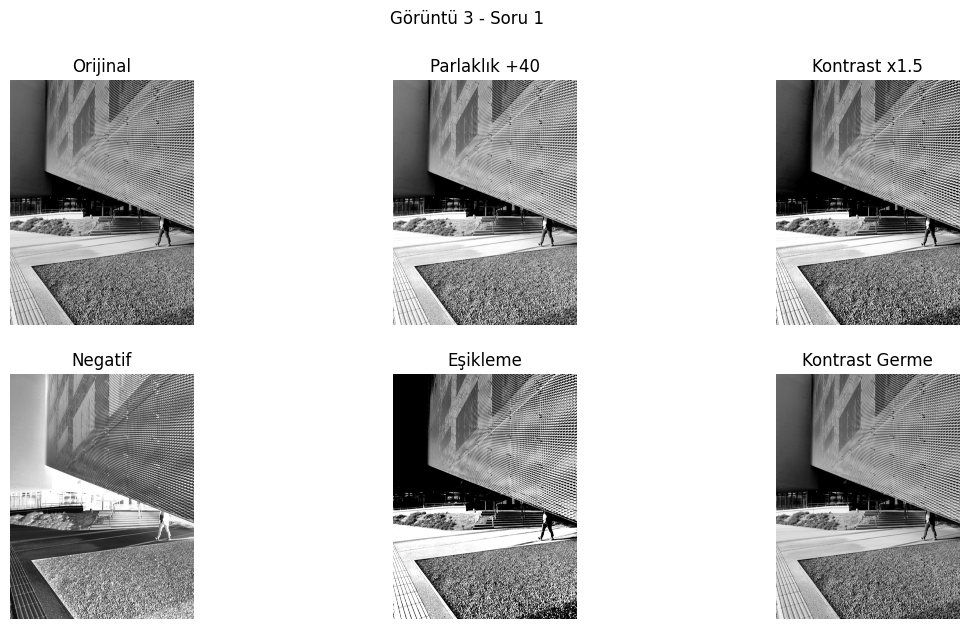

Görüntü 3 Soru 2 -> Mean=122.43, Std=86.60, Entropy=7.685, Min=0, Max=255


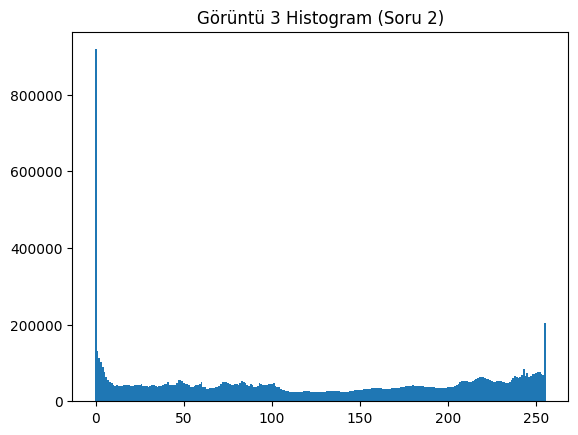

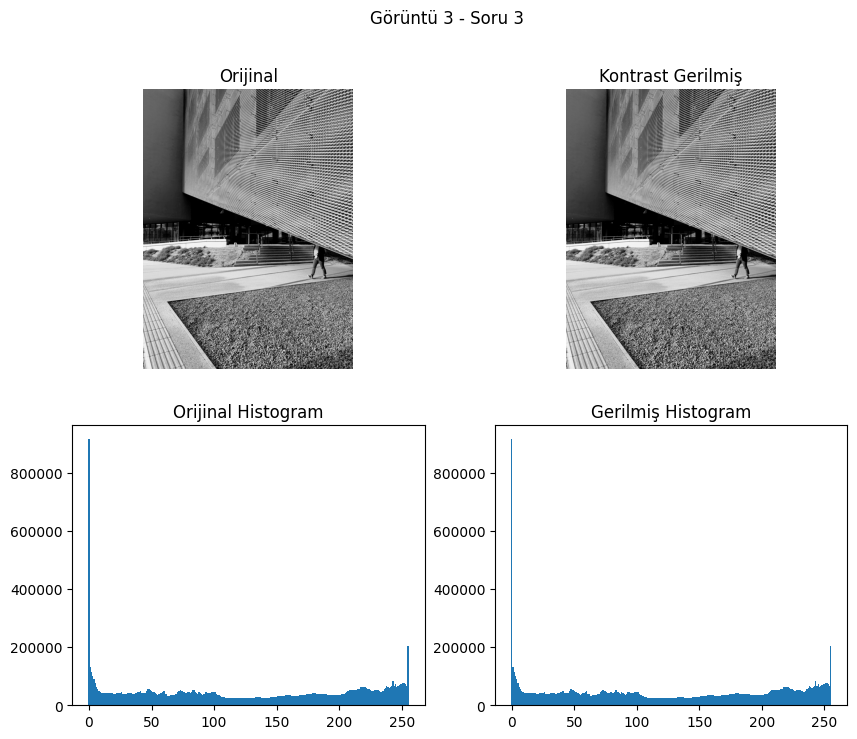

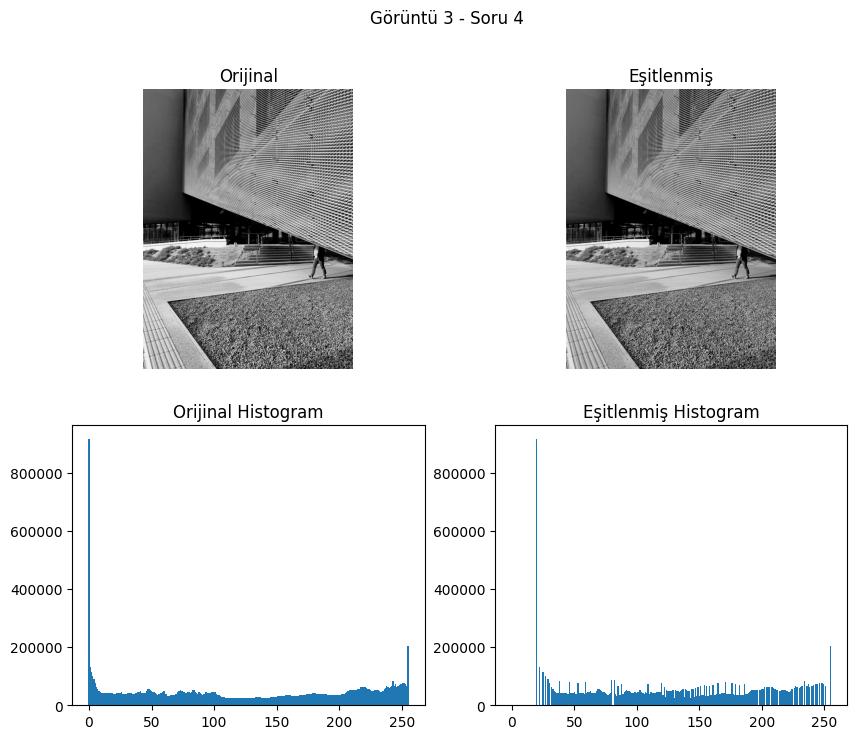

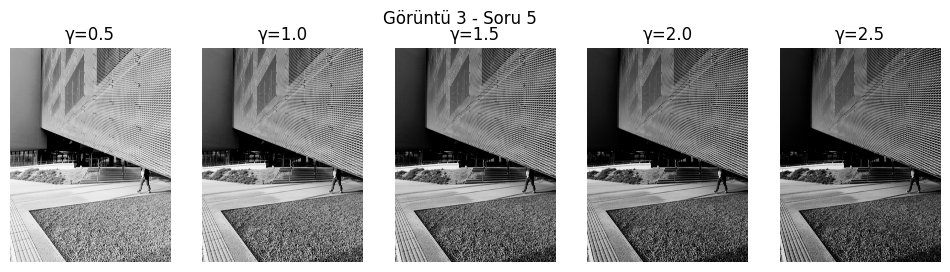


✅ TÜM ÇIKTILAR KAYDEDİLDİ.
Artık ZIP yapabilirsin:
!zip -r ciktilar.zip .


In [11]:
"""
Bilgisayarla Görü - Ödev 3 (Tam Çalışır + Açıklamalı + Çıktı Kaydedici)
Girdi: 1, 2, 3 adlı görüntüler (renkli olabilir) -> otomatik griye çevrilir
Çıktı: Her soru için .png dosyaları otomatik kaydedilir
"""

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

#-----------------------------------
# Görüntü dosyasını uzantısından bağımsız bul
#-----------------------------------
def resolve_path(basename):
    extensions = [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"]
    for ext in extensions:
        if os.path.exists(basename + ext):
            return basename + ext
    if os.path.exists(basename):
        return basename
    raise FileNotFoundError(f"Görüntü bulunamadı: {basename}")

#-----------------------------------
# Görüntüyü gri seviye olarak yükle
#-----------------------------------
def load_as_gray(path):
    return np.array(Image.open(path).convert("L"), dtype=np.uint8)

#-----------------------------------
# Soru 1 – Nokta İşlemleri
#-----------------------------------
def adjust_brightness(img, value):
    out = img.astype(np.int16) + value
    return np.clip(out, 0, 255).astype(np.uint8)

def adjust_contrast(img, factor):
    out = factor * (img.astype(np.float32) - 128) + 128
    return np.clip(out, 0, 255).astype(np.uint8)

def negative(img):
    return 255 - img

def threshold(img, t):
    return np.where(img > t, 255, 0).astype(np.uint8)

#-----------------------------------
# Soru 2 – Histogram + İstatistik
#-----------------------------------
def histogram_manual(img):
    return np.bincount(img.ravel(), minlength=256)

def stats(img):
    hist = histogram_manual(img).astype(float)
    p = hist / img.size
    entropy = -np.sum(p[p>0] * np.log2(p[p>0]))
    return img.mean(), img.std(), entropy, img.min(), img.max()

def plot_hist(ax, hist, title):
    ax.bar(np.arange(256), hist, width=1)
    ax.set_title(title)

#-----------------------------------
# Soru 3 – Kontrast Germe
#-----------------------------------
def contrast_stretch(img):
    mn, mx = img.min(), img.max()
    if mn == mx:
        return img.copy()
    stretched = ((img - mn) / (mx - mn) * 255)
    return stretched.astype(np.uint8)

#-----------------------------------
# Soru 4 – Histogram Eşitleme (Manuel)
#-----------------------------------
def hist_equalize_manual(img):
    hist = histogram_manual(img).astype(float)
    cdf = np.cumsum(hist) / img.size
    lut = np.round(255 * cdf).astype(np.uint8)
    return lut[img]

#-----------------------------------
# Soru 5 – Gamma Düzeltme
#-----------------------------------
def gamma_correct(img, gamma):
    x = img.astype(np.float32) / 255
    y = 255 * (x ** gamma)
    return y.astype(np.uint8)

#-----------------------------------
# Görselleştirme ve Kaydetme
#-----------------------------------
def run_for_image(basename):

    img = load_as_gray(resolve_path(basename))

    # ---- SORU 1 ----
    plt.figure(figsize=(14,7))
    ops = [
        ("Orijinal", img),
        ("Parlaklık +40", adjust_brightness(img,40)),
        ("Kontrast x1.5", adjust_contrast(img,1.5)),
        ("Negatif", negative(img)),
        ("Eşikleme", threshold(img,120)),
        ("Kontrast Germe", contrast_stretch(img))
    ]
    for i,(t,im) in enumerate(ops,1):
        plt.subplot(2,3,i); plt.imshow(im,cmap='gray'); plt.title(t); plt.axis('off')
    plt.suptitle(f"Görüntü {basename} - Soru 1")
    plt.savefig(f"{basename}_soru1.png", dpi=300)
    plt.show()

    # ---- SORU 2 ----
    h = histogram_manual(img)
    m,s,e,mn,mx = stats(img)
    print(f"Görüntü {basename} Soru 2 -> Mean={m:.2f}, Std={s:.2f}, Entropy={e:.3f}, Min={mn}, Max={mx}")
    plt.figure()
    plot_hist(plt.gca(), h, f"Görüntü {basename} Histogram (Soru 2)")
    plt.savefig(f"{basename}_soru2_hist.png", dpi=300)
    plt.show()

    # ---- SORU 3 ----
    stretched = contrast_stretch(img)
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1); plt.imshow(img,cmap='gray'); plt.title("Orijinal"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(stretched,cmap='gray'); plt.title("Kontrast Gerilmiş"); plt.axis("off")
    plt.subplot(2,2,3); plot_hist(plt.gca(), histogram_manual(img), "Orijinal Histogram")
    plt.subplot(2,2,4); plot_hist(plt.gca(), histogram_manual(stretched), "Gerilmiş Histogram")
    plt.suptitle(f"Görüntü {basename} - Soru 3")
    plt.savefig(f"{basename}_soru3_kontrast.png", dpi=300)
    plt.show()

    # ---- SORU 4 ----
    eq = hist_equalize_manual(img)
    plt.figure(figsize=(10,8))
    plt.subplot(2,2,1); plt.imshow(img,cmap='gray'); plt.title("Orijinal"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(eq,cmap='gray'); plt.title("Eşitlenmiş"); plt.axis("off")
    plt.subplot(2,2,3); plot_hist(plt.gca(), histogram_manual(img), "Orijinal Histogram")
    plt.subplot(2,2,4); plot_hist(plt.gca(), histogram_manual(eq), "Eşitlenmiş Histogram")
    plt.suptitle(f"Görüntü {basename} - Soru 4")
    plt.savefig(f"{basename}_soru4_esitleme.png", dpi=300)
    plt.show()

    # ---- SORU 5 ----
    gammas = [0.5,1.0,1.5,2.0,2.5]
    plt.figure(figsize=(12,3))
    for i,g in enumerate(gammas,1):
        plt.subplot(1,5,i); plt.imshow(gamma_correct(img,g), cmap='gray')
        plt.title(f"γ={g}"); plt.axis("off")
    plt.suptitle(f"Görüntü {basename} - Soru 5")
    plt.savefig(f"{basename}_soru5_gamma.png", dpi=300)
    plt.show()

#-----------------------------------
# Çalıştır
#-----------------------------------
for b in ["1","2","3"]:
    run_for_image(b)

print("\n TÜM ÇIKTILAR KAYDEDİLDİ.\nArtık ZIP yapabilirsin:")
print("!zip -r ciktilar.zip .")


In [13]:
from google.colab import files
!zip -r ciktilar_final.zip .
files.download("ciktilar_final.zip")


  adding: .config/ (stored 0%)
  adding: .config/gce (stored 0%)
  adding: .config/.last_opt_in_prompt.yaml (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/configurations/ (stored 0%)
  adding: .config/configurations/config_default (deflated 15%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .config/.last_update_check.json (deflated 23%)
  adding: .config/logs/ (stored 0%)
  adding: .config/logs/2025.11.05/ (stored 0%)
  adding: .config/logs/2025.11.05/14.33.53.434728.log (deflated 57%)
  adding: .config/logs/2025.11.05/14.33.36.385956.log (deflated 58%)
  adding: .config/logs/2025.11.05/14.33.45.559498.log (deflated 58%)
  adding: .config/logs/2025.11.05/14.33.13.470069.log (deflated 93%)
  adding: .config/logs/2025.11.05/14.33.44.287731.log (deflated 86%)
  adding: .config/logs/2025.11.05/14.33.54.129583.log (deflated 56%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/hi

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>